In [ ]:
from google. colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import json
import cv2
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn import (
    preprocessing,
    model_selection,
    metrics,
)

In [ ]:
SEED = 42
np.random.seed = SEED
tf.random.set_seed = SEED

In [ ]:
train_dataset = pd.read_csv('/content/drive/MyDrive/train.csv')
train_dataset.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [ ]:
classes = ['No DR','Mild','Moderate','Severe','Proliferative DR']

In [ ]:
PATH = '/content/drive/MyDrive/train_images'

file_paths = []
labels = []

for i in range(0,len(train_dataset)):
    file_paths.append(PATH + train_dataset.id_code[i] + '.png')
    labels.append(train_dataset.diagnosis[i])

path_series = pd.Series(file_paths, name='filepath')
label_series = pd.Series(labels, name='label')
training_data = pd.concat([path_series, label_series], axis=1)
training_data.head()


filepath  label
0  /content/drive/MyDrive/train_images000c1434d8d...      2
1  /content/drive/MyDrive/train_images001639a390f...      4
2  /content/drive/MyDrive/train_images0024cdab0c1...      1
3  /content/drive/MyDrive/train_images002c21358ce...      0
4  /content/drive/MyDrive/train_images005b95c2885...      0

In [ ]:
dest_path = '/content/'

os.mkdir(dest_path + 'filtered_train_images')

In [ ]:
train_source_path = '/content/drive/MyDrive/train_images/'
train_des_path = '/content/filtered_train_images/'

for img in tqdm.tqdm(os.listdir(train_source_path)):
    shutil.copy(train_source_path + img,train_des_path)

100%|██████████| 3662/3662 [14:07<00:00,  4.32it/s]


In [ ]:
def gaussian_filter(path):
    sigmaX = 15
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gaussian = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), sigmaX), -4, 128)
    gaussian = cv2.resize(gaussian, (224, 224))
    cv2.imwrite(path,gaussian)


In [ ]:
for img in tqdm.tqdm(os.listdir(train_des_path)):
    gaussian_filter(train_des_path + img)

100%|██████████| 3662/3662 [26:47<00:00,  2.28it/s]


In [ ]:
PATH = '/content/filtered_train_images/'

file_paths = []
labels = []

for i in range(0,len(train_dataset)):
    file_paths.append(PATH + train_dataset.id_code[i] + '.png')
    labels.append(train_dataset.diagnosis[i])

path_series = pd.Series(file_paths, name='filepath')
label_series = pd.Series(labels, name='label')
training_data = pd.concat([path_series, label_series], axis=1)
training_data.head()

filepath  label
0  /content/filtered_train_images/000c1434d8d7.png      2
1  /content/filtered_train_images/001639a390f0.png      4
2  /content/filtered_train_images/0024cdab0c1e.png      1
3  /content/filtered_train_images/002c21358ce6.png      0
4  /content/filtered_train_images/005b95c28852.png      0

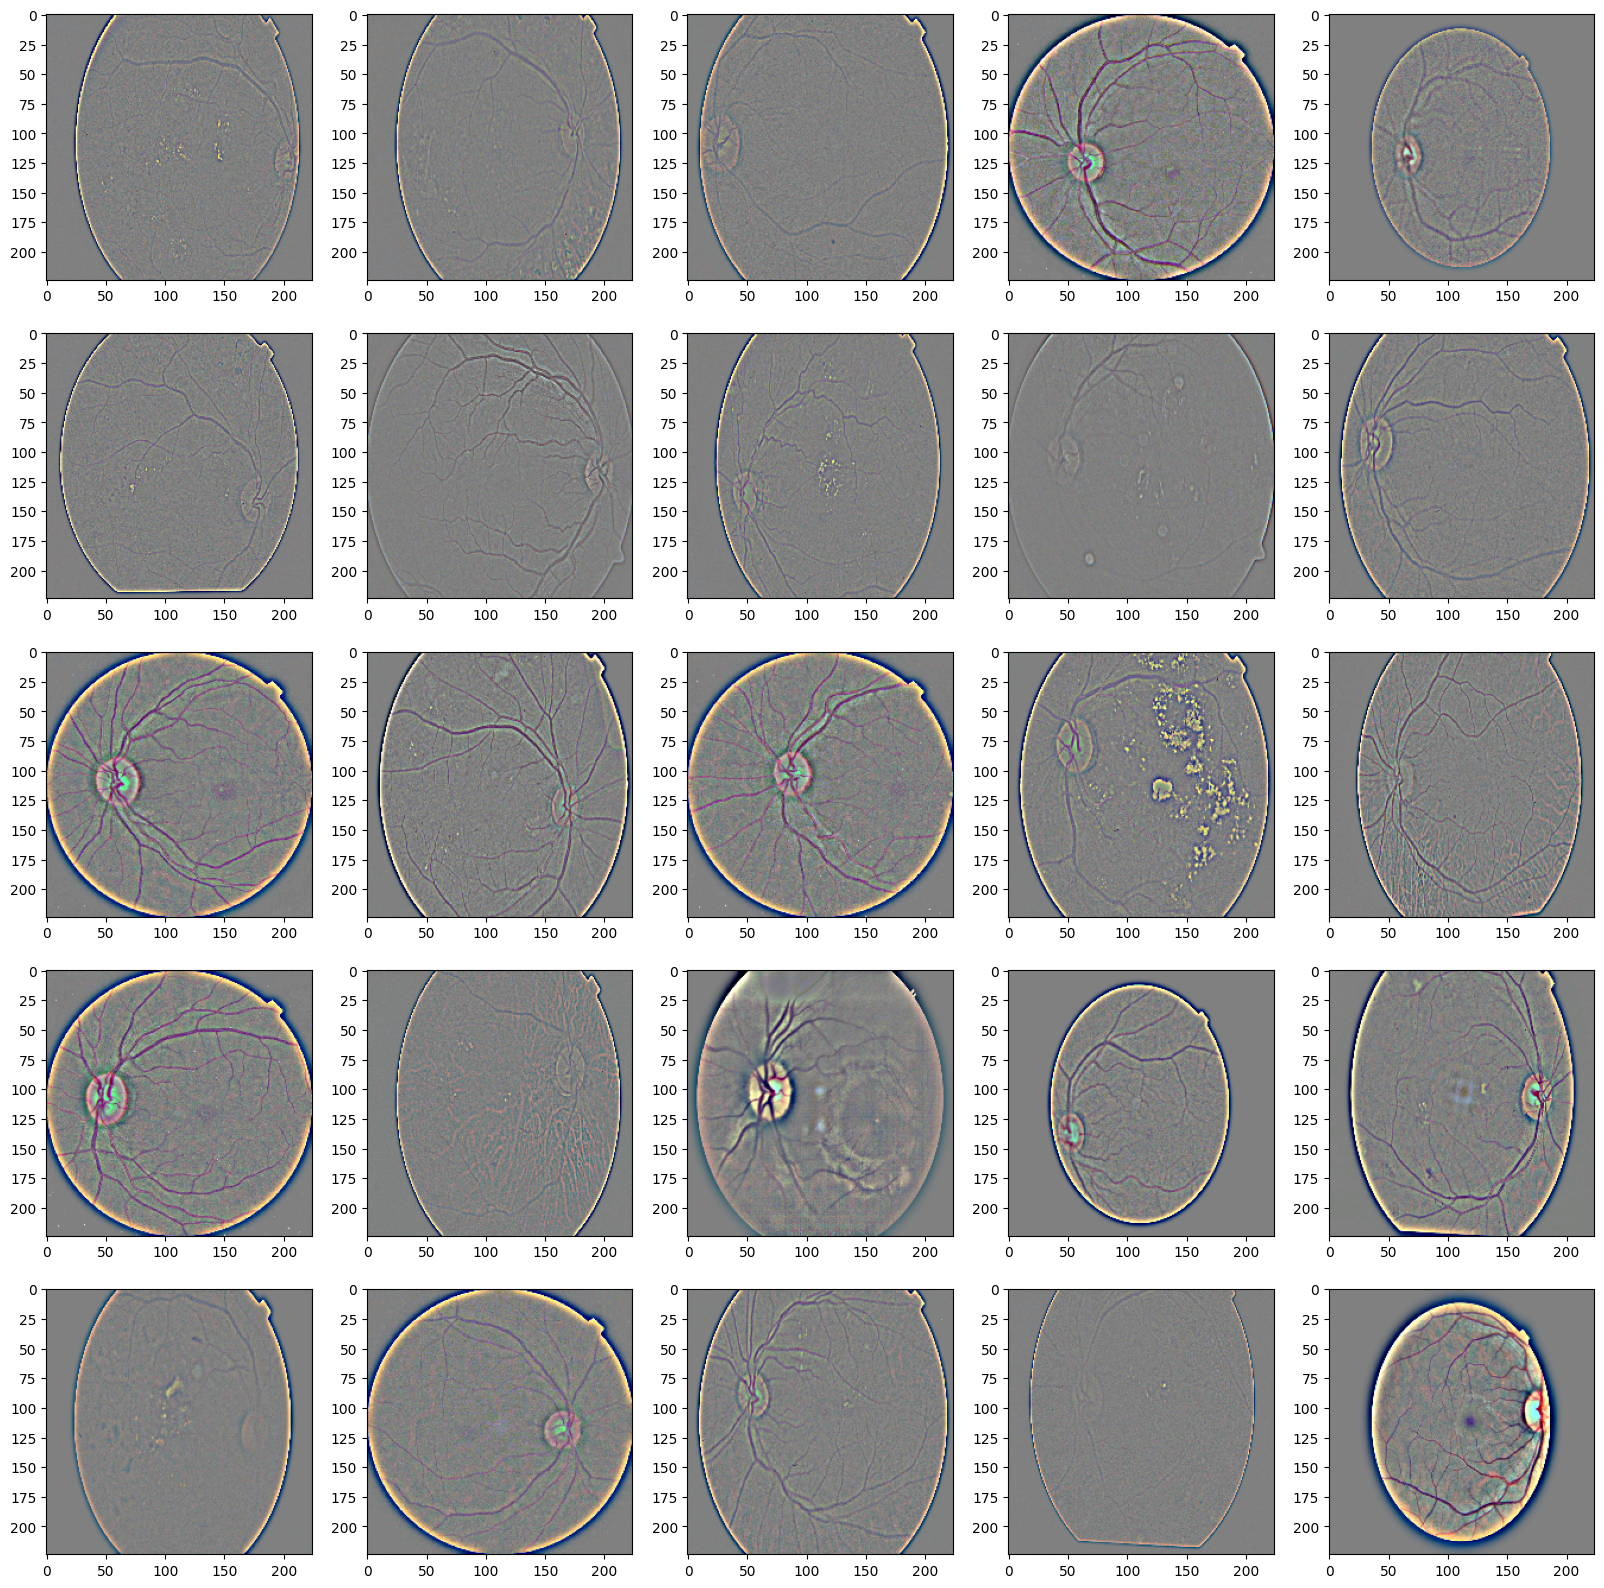

In [ ]:
plt.figure(figsize=(20, 20))
for idx in range(0,25):
    image = cv2.imread(training_data.filepath[idx])
    plt.subplot(5,5,idx+1)
    plt.imshow(image)
plt.show()

In [ ]:
mask = np.random.rand(len(training_data)) < 0.8
train = training_data[mask]
test = training_data[~mask]

print('Training Data Size :- ',train.shape)
print('Testing Data Size :- ',test.shape)

Training Data Size :-  (2916, 2)
Testing Data Size :-  (746, 2)


In [ ]:
import os
import shutil

# Specify the destination path for the test data
test_dest_path = '/content/test_images'

# Create the destination folder if it does not exist
os.makedirs(test_dest_path, exist_ok=True)

# Iterate through the test data and copy images to the destination folder
for img_path in test['filepath']:
    img_name = os.path.basename(img_path)
    shutil.copy(img_path, os.path.join(test_dest_path, img_name))


In [ ]:
import os
import shutil
import pandas as pd

# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/train.csv')  # Replace 'path_to_your_train.csv' with the actual path

# Mapping dictionary for diagnosis codes to labels
diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

# Create a new 'label' column based on the 'diagnosis' column
df['label'] = df['diagnosis'].map(diagnosis_dict)

# Create working directories
base_dir = '/content/drive/MyDrive/test_images'  # Replace 'path_to_your_base_directory' with the actual path

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.makedirs(base_dir)

# Copy images to respective working directory
src_dir = '/content/test_images'  # Replace 'path_to_your_source_directory' with the actual path

for index, row in df.iterrows():
    diagnosis_label = row['label']
    id_code = str(row['id_code']) + '.png'   # Convert id_code to string and add '.png'
    srcfile = os.path.join(src_dir, id_code)
    dstfile = os.path.join(base_dir, diagnosis_label)
    os.makedirs(dstfile, exist_ok=True)

    # Check if the source file exists before copying
    if os.path.exists(srcfile):
        shutil.copy(srcfile, dstfile)




In [ ]:
x = train.filepath
y = train.label

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (5,5), padding="same", input_shape=(224,224,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128, (5,5), padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128, (5,5), padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128, (5,5), padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(256, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128,activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(len(classes), activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     409728    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       409728    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0

In [ ]:
path = '/content/drive/MyDrive/train.csv'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)


kfold = model_selection.StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

# Variable for keeping count of split we are executing
j = 0

model_history = []

# K-fold Train and test for each split
for train_idx, val_idx in tqdm.tqdm(list(kfold.split(x,y))):
    x_train_df = training_data.iloc[train_idx]
    x_valid_df = training_data.iloc[val_idx]

    j+=1

    training_set = train_datagen.flow_from_dataframe(dataframe=x_train_df, directory=path,
                                                 x_col="filepath", y_col="label",
                                                 class_mode="raw",
                                                 target_size=(224,224), batch_size=32)

    validation_set = validation_datagen.flow_from_dataframe(dataframe=x_valid_df, directory=path,
                                                 x_col="filepath", y_col="label",
                                                 class_mode="raw",
                                                 target_size=(224,224), batch_size=32)

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', mode='max', restore_best_weights=True)

    history = model.fit(training_set,validation_data=validation_set,epochs = 10,callbacks=[early_stopping])

    model_history.append(history)

  0%|          | 0/10 [00:00<?, ?it/s]

Found 2624 validated image filenames.
Found 292 validated image filenames.
Epoch 1/10
82/82 [==============================] - 66s 594ms/step - loss: 1.2216 - accuracy: 0.5164 - val_loss: 0.8938 - val_accuracy: 0.6952
Epoch 2/10
82/82 [==============================] - 45s 553ms/step - loss: 1.0101 - accuracy: 0.6383 - val_loss: 0.8564 - val_accuracy: 0.7226
Epoch 3/10
82/82 [==============================] - 43s 529ms/step - loss: 0.9385 - accuracy: 0.6738 - val_loss: 0.9683 - val_accuracy: 0.7158
Epoch 4/10
82/82 [==============================] - 43s 529ms/step - loss: 0.9047 - accuracy: 0.6825 - val_loss: 0.8778 - val_accuracy: 0.7260
Epoch 5/10
82/82 [==============================] - 44s 534ms/step - loss: 0.8939 - accuracy: 0.6879 - val_loss: 0.8057 - val_accuracy: 0.7226
Epoch 6/10
82/82 [==============================] - 42s 507ms/step - loss: 0.8781 - accuracy: 0.6902 - val_loss: 0.8326 - val_accuracy: 0.7226
Epoch 7/10
82/82 [==============================] - 43s 527ms/step 

 10%|█         | 1/10 [08:55<1:20:20, 535.64s/it]

Found 2624 validated image filenames.
Found 292 validated image filenames.
Epoch 1/10
82/82 [==============================] - 42s 508ms/step - loss: 0.8215 - accuracy: 0.7077 - val_loss: 0.6503 - val_accuracy: 0.7705
Epoch 2/10
82/82 [==============================] - 45s 539ms/step - loss: 0.8146 - accuracy: 0.7062 - val_loss: 0.6809 - val_accuracy: 0.7740
Epoch 3/10
82/82 [==============================] - 43s 521ms/step - loss: 0.8022 - accuracy: 0.7027 - val_loss: 0.6377 - val_accuracy: 0.7637
Epoch 4/10
82/82 [==============================] - 43s 519ms/step - loss: 0.7785 - accuracy: 0.7134 - val_loss: 0.6575 - val_accuracy: 0.7705
Epoch 5/10
82/82 [==============================] - 41s 502ms/step - loss: 0.7719 - accuracy: 0.7207 - val_loss: 0.6357 - val_accuracy: 0.7808
Epoch 6/10
82/82 [==============================] - 43s 517ms/step - loss: 0.7613 - accuracy: 0.7119 - val_loss: 0.6647 - val_accuracy: 0.7705
Epoch 7/10
82/82 [==============================] - 46s 559ms/step 

 20%|██        | 2/10 [16:04<1:03:04, 473.02s/it]

Found 2624 validated image filenames.
Found 292 validated image filenames.
Epoch 1/10
82/82 [==============================] - 43s 520ms/step - loss: 0.7173 - accuracy: 0.7374 - val_loss: 0.7196 - val_accuracy: 0.7158
Epoch 2/10
82/82 [==============================] - 43s 525ms/step - loss: 0.7121 - accuracy: 0.7332 - val_loss: 0.6367 - val_accuracy: 0.7740
Epoch 3/10
82/82 [==============================] - 45s 550ms/step - loss: 0.6882 - accuracy: 0.7473 - val_loss: 0.6718 - val_accuracy: 0.7534
Epoch 4/10
82/82 [==============================] - 40s 486ms/step - loss: 0.6898 - accuracy: 0.7420 - val_loss: 0.6511 - val_accuracy: 0.7774
Epoch 5/10
82/82 [==============================] - 39s 473ms/step - loss: 0.6744 - accuracy: 0.7477 - val_loss: 0.6541 - val_accuracy: 0.7500
Epoch 6/10
82/82 [==============================] - 41s 496ms/step - loss: 0.6698 - accuracy: 0.7550 - val_loss: 0.6293 - val_accuracy: 0.7911
Epoch 7/10
82/82 [==============================] - 41s 496ms/step 

 30%|███       | 3/10 [24:24<56:37, 485.41s/it]  

Found 2624 validated image filenames.
Found 292 validated image filenames.
Epoch 1/10
82/82 [==============================] - 41s 498ms/step - loss: 0.6319 - accuracy: 0.7649 - val_loss: 0.6311 - val_accuracy: 0.7500
Epoch 2/10
82/82 [==============================] - 39s 479ms/step - loss: 0.6167 - accuracy: 0.7652 - val_loss: 0.6318 - val_accuracy: 0.7329
Epoch 3/10
82/82 [==============================] - 42s 507ms/step - loss: 0.6147 - accuracy: 0.7698 - val_loss: 0.6325 - val_accuracy: 0.7397
Epoch 4/10
82/82 [==============================] - 41s 499ms/step - loss: 0.6006 - accuracy: 0.7729 - val_loss: 0.6392 - val_accuracy: 0.7226
Epoch 5/10
82/82 [==============================] - 40s 487ms/step - loss: 0.6018 - accuracy: 0.7740 - val_loss: 0.6138 - val_accuracy: 0.7500
Epoch 6/10
82/82 [==============================] - 39s 471ms/step - loss: 0.5884 - accuracy: 0.7816 - val_loss: 0.6358 - val_accuracy: 0.7603
Epoch 7/10
82/82 [==============================] - 43s 524ms/step 

 40%|████      | 4/10 [31:59<47:19, 473.33s/it]

Found 2624 validated image filenames.
Found 292 validated image filenames.
Epoch 1/10
82/82 [==============================] - 39s 476ms/step - loss: 0.5456 - accuracy: 0.7908 - val_loss: 0.4640 - val_accuracy: 0.8253
Epoch 2/10
82/82 [==============================] - 41s 501ms/step - loss: 0.5598 - accuracy: 0.7915 - val_loss: 0.4401 - val_accuracy: 0.8356
Epoch 3/10
82/82 [==============================] - 42s 516ms/step - loss: 0.5511 - accuracy: 0.7984 - val_loss: 0.4665 - val_accuracy: 0.8219
Epoch 4/10
82/82 [==============================] - 39s 469ms/step - loss: 0.5229 - accuracy: 0.8007 - val_loss: 0.4623 - val_accuracy: 0.8322
Epoch 5/10
82/82 [==============================] - 41s 500ms/step - loss: 0.5307 - accuracy: 0.7969 - val_loss: 0.5154 - val_accuracy: 0.8219
Epoch 6/10
82/82 [==============================] - 40s 486ms/step - loss: 0.5179 - accuracy: 0.8068 - val_loss: 0.4790 - val_accuracy: 0.8082
Epoch 7/10
82/82 [==============================] - 39s 472ms/step 

 50%|█████     | 5/10 [37:21<34:54, 418.81s/it]

Found 2624 validated image filenames.
Found 292 validated image filenames.
Epoch 1/10
82/82 [==============================] - 43s 525ms/step - loss: 0.5448 - accuracy: 0.7992 - val_loss: 0.4641 - val_accuracy: 0.8116
Epoch 2/10
82/82 [==============================] - 40s 490ms/step - loss: 0.5530 - accuracy: 0.8003 - val_loss: 0.4356 - val_accuracy: 0.8459
Epoch 3/10
82/82 [==============================] - 39s 475ms/step - loss: 0.5266 - accuracy: 0.8045 - val_loss: 0.4312 - val_accuracy: 0.8288
Epoch 4/10
82/82 [==============================] - 41s 495ms/step - loss: 0.5094 - accuracy: 0.8045 - val_loss: 0.4346 - val_accuracy: 0.8322
Epoch 5/10
82/82 [==============================] - 40s 488ms/step - loss: 0.5153 - accuracy: 0.8075 - val_loss: 0.4396 - val_accuracy: 0.8390
Epoch 6/10
82/82 [==============================] - 39s 475ms/step - loss: 0.5122 - accuracy: 0.8045 - val_loss: 0.4335 - val_accuracy: 0.8527
Epoch 7/10
82/82 [==============================] - 43s 527ms/step 

 60%|██████    | 6/10 [44:10<27:41, 415.27s/it]

Found 2625 validated image filenames.
Found 291 validated image filenames.
Epoch 1/10
83/83 [==============================] - 42s 504ms/step - loss: 0.4734 - accuracy: 0.8145 - val_loss: 0.4979 - val_accuracy: 0.8110
Epoch 2/10
83/83 [==============================] - 42s 507ms/step - loss: 0.4718 - accuracy: 0.8255 - val_loss: 0.4984 - val_accuracy: 0.8144
Epoch 3/10
83/83 [==============================] - 40s 473ms/step - loss: 0.4480 - accuracy: 0.8331 - val_loss: 0.4609 - val_accuracy: 0.8316
Epoch 4/10
83/83 [==============================] - 41s 493ms/step - loss: 0.4866 - accuracy: 0.8187 - val_loss: 0.4886 - val_accuracy: 0.8213
Epoch 5/10
83/83 [==============================] - 41s 495ms/step - loss: 0.4471 - accuracy: 0.8354 - val_loss: 0.5068 - val_accuracy: 0.8076
Epoch 6/10
83/83 [==============================] - 39s 470ms/step - loss: 0.4391 - accuracy: 0.8392 - val_loss: 0.5198 - val_accuracy: 0.8247
Epoch 7/10
83/83 [==============================] - 43s 520ms/step 

 70%|███████   | 7/10 [51:00<20:41, 413.68s/it]

Found 2625 validated image filenames.
Found 291 validated image filenames.
Epoch 1/10
83/83 [==============================] - 40s 480ms/step - loss: 0.4360 - accuracy: 0.8354 - val_loss: 0.3773 - val_accuracy: 0.8557
Epoch 2/10
83/83 [==============================] - 40s 473ms/step - loss: 0.4411 - accuracy: 0.8419 - val_loss: 0.3816 - val_accuracy: 0.8454
Epoch 3/10
83/83 [==============================] - 41s 491ms/step - loss: 0.4447 - accuracy: 0.8290 - val_loss: 0.3542 - val_accuracy: 0.8625
Epoch 4/10
83/83 [==============================] - 39s 466ms/step - loss: 0.4199 - accuracy: 0.8350 - val_loss: 0.3723 - val_accuracy: 0.8488
Epoch 5/10
83/83 [==============================] - 43s 517ms/step - loss: 0.5125 - accuracy: 0.8126 - val_loss: 0.3576 - val_accuracy: 0.8454
Epoch 6/10
83/83 [==============================] - 41s 491ms/step - loss: 0.4192 - accuracy: 0.8465 - val_loss: 0.4171 - val_accuracy: 0.8076
Epoch 7/10
83/83 [==============================] - 39s 466ms/step 

 80%|████████  | 8/10 [56:25<12:50, 385.46s/it]

Found 2625 validated image filenames.
Found 291 validated image filenames.
Epoch 1/10
83/83 [==============================] - 41s 494ms/step - loss: 0.4331 - accuracy: 0.8331 - val_loss: 0.3517 - val_accuracy: 0.8591
Epoch 2/10
83/83 [==============================] - 39s 474ms/step - loss: 0.4218 - accuracy: 0.8408 - val_loss: 0.2766 - val_accuracy: 0.8900
Epoch 3/10
83/83 [==============================] - 43s 510ms/step - loss: 0.4175 - accuracy: 0.8457 - val_loss: 0.3532 - val_accuracy: 0.8660
Epoch 4/10
83/83 [==============================] - 42s 496ms/step - loss: 0.4306 - accuracy: 0.8377 - val_loss: 0.2912 - val_accuracy: 0.8969
Epoch 5/10
83/83 [==============================] - 41s 491ms/step - loss: 0.4146 - accuracy: 0.8461 - val_loss: 0.3512 - val_accuracy: 0.8625
Epoch 6/10
83/83 [==============================] - 39s 473ms/step - loss: 0.4072 - accuracy: 0.8446 - val_loss: 0.3065 - val_accuracy: 0.8832
Epoch 7/10
83/83 [==============================] - 41s 488ms/step 

 90%|█████████ | 9/10 [1:03:54<06:45, 405.10s/it]

Found 2625 validated image filenames.
Found 291 validated image filenames.
Epoch 1/10
83/83 [==============================] - 39s 467ms/step - loss: 0.4102 - accuracy: 0.8495 - val_loss: 0.3539 - val_accuracy: 0.8660
Epoch 2/10
83/83 [==============================] - 41s 491ms/step - loss: 0.4004 - accuracy: 0.8518 - val_loss: 0.3938 - val_accuracy: 0.8282
Epoch 3/10
83/83 [==============================] - 40s 477ms/step - loss: 0.3840 - accuracy: 0.8583 - val_loss: 0.3722 - val_accuracy: 0.8488
Epoch 4/10
83/83 [==============================] - 41s 493ms/step - loss: 0.3898 - accuracy: 0.8575 - val_loss: 0.4587 - val_accuracy: 0.8179
Epoch 5/10
83/83 [==============================] - 41s 489ms/step - loss: 0.4475 - accuracy: 0.8278 - val_loss: 0.3590 - val_accuracy: 0.8660
Epoch 6/10
83/83 [==============================] - 40s 479ms/step - loss: 0.3820 - accuracy: 0.8602 - val_loss: 0.4046 - val_accuracy: 0.8351


100%|██████████| 10/10 [1:07:58<00:00, 407.83s/it]


In [ ]:
model.save("/content/drive/MyDrive/emodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
acc,val_acc,loss,val_loss = [],[],[],[]
for idx in range(0,len(model_history)):
    acc.extend(model_history[idx].history['accuracy'])
    val_acc.extend(model_history[idx].history['val_accuracy'])

    loss.extend(model_history[idx].history['loss'])
    val_loss.extend(model_history[idx].history['val_loss'])

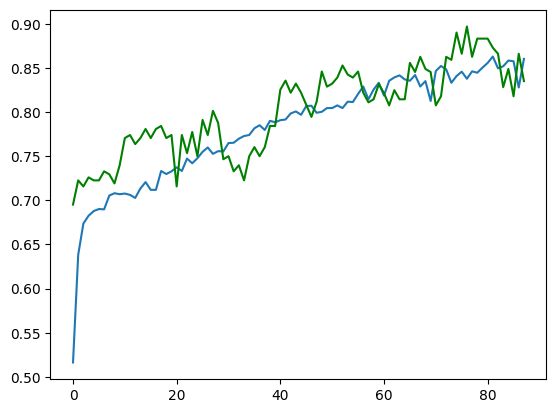

In [ ]:
plt.plot(acc)
plt.plot(val_acc,color = 'green')
plt.show()

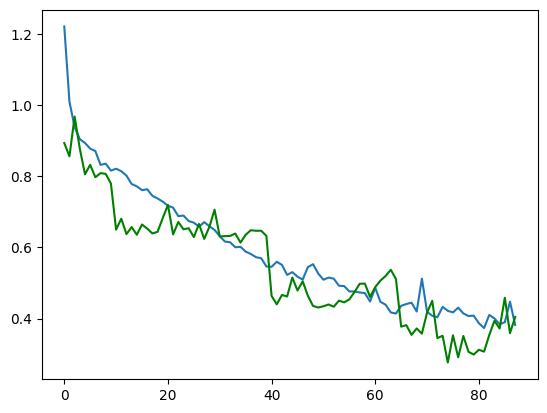

In [ ]:
plt.plot(loss)
plt.plot(val_loss,color = 'green')
plt.show()

In [ ]:

model_infos = {
  "loss": loss,
  "accuracy": acc,
  "val_loss": val_loss,
  "val_acc" : val_acc
}

with open("/content//drive/MyDrive/model_history.json", "w") as outfile:
    json.dump(model_infos, outfile)

In [ ]:
pathopt = '/content/drive/MyDrive/test_images'
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_dataframe(dataframe=test, directory=pathopt,
                                                 x_col="filepath", y_col="label",
                                                 class_mode="raw",
                                                 target_size=(224,224), batch_size=32)

Found 746 validated image filenames.


In [ ]:
model.evaluate(test_set)

24/24 [==============================] - 4s 164ms/step - loss: 0.4228 - accuracy: 0.8579


[0.4228009879589081, 0.8579088449478149]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming 'model' is the CNN model you've trained
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

# Evaluate the model on the test set
test_evaluation = model.evaluate(test_set)

# Print the overall test accuracy
print(f"Overall Test Accuracy: {test_evaluation[1] * 100:.2f}%")

# Evaluate the model on the test set and get predictions
y_pred = model.predict(test_set)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.array(test['label'])

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print test accuracy for each class
for i, class_name in enumerate(class_names):
    class_mask = y_true_classes == i
    class_accuracy = np.sum(y_true_classes[class_mask] == y_pred_classes[class_mask]) / np.sum(class_mask)
    print(f"Test Accuracy for {class_name}: {class_accuracy * 100:.2f}%")

# Generate and print classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("\nClassification Report:")
print(class_report)


24/24 [==============================] - 3s 109ms/step - loss: 0.4228 - accuracy: 0.8579
Overall Test Accuracy: 85.79%
24/24 [==============================] - 2s 85ms/step
Confusion Matrix:
[[191  39 125  11  13]
 [ 45   9  29   4   3]
 [ 93  30  42  12   5]
 [ 21   3  15   2   2]
 [ 26   5  18   2   1]]
Test Accuracy for No DR: 50.40%
Test Accuracy for Mild: 10.00%
Test Accuracy for Moderate: 23.08%
Test Accuracy for Severe: 4.65%
Test Accuracy for Proliferative DR: 1.92%

Classification Report:
                  precision    recall  f1-score   support

           No DR       0.51      0.50      0.51       379
            Mild       0.10      0.10      0.10        90
        Moderate       0.18      0.23      0.20       182
          Severe       0.06      0.05      0.05        43
Proliferative DR       0.04      0.02      0.03        52

        accuracy                           0.33       746
       macro avg       0.18      0.18      0.18       746
    weighted avg       0.32    

24/24 [==============================] - 3s 133ms/step


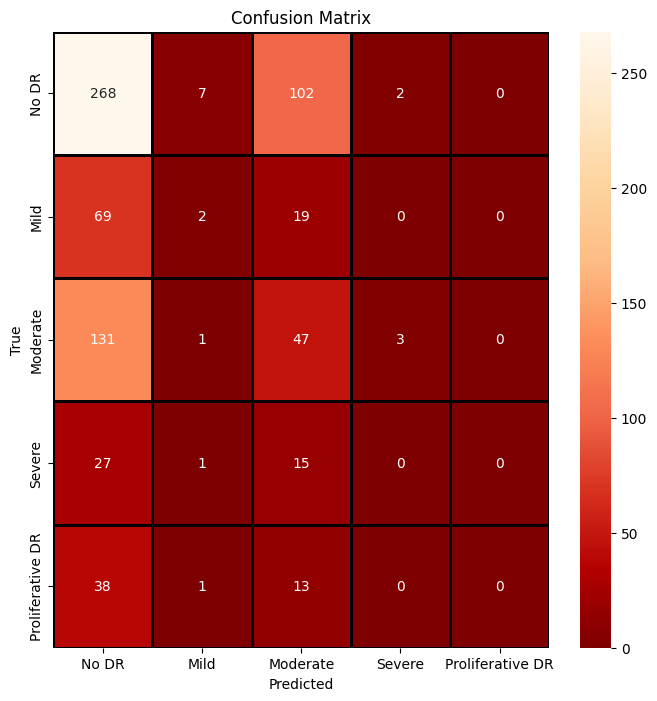

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# Assuming 'model' is the CNN model you've trained
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

# Evaluate the model on the test set and get predictions
y_pred = model.predict(test_set)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.array(test['label'])

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Create a DataFrame for the confusion matrix
confusionMatrix = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plot the confusion matrix with a color range guide
plt.figure(figsize=(8, 8))
sns.heatmap(confusionMatrix, cmap="OrRd_r", linecolor='black', linewidth=1, annot=True, fmt='', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Function to preprocess the image
def preprocess_image(image_path):
    # Load and resize the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    # Apply the same preprocessing used during training
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 15), -4, 128)
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to make predictions using the trained model
def predict_image(model, image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    predicted_class = np.argmax(prediction)
    return predicted_class

# Path to the image you want to test
image_to_test_path = '/content/drive/MyDrive/test_images/Moderate/10eefba568dd.png'

# Load the trained model
# Make sure to replace 'your_model_path' with the actual path to your saved model
model_path = '/content/drive/MyDrive/emodel.h5'
model = tf.keras.models.load_model(model_path)

# Perform prediction
predicted_class = predict_image(model, image_to_test_path)

# Map the predicted class to the corresponding label
diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}
predicted_label = diagnosis_dict[predicted_class]

print(f"Predicted class: {predicted_class} - {predicted_label}")


1/1 [==============================] - 0s 439ms/step
Predicted class: 2 - Moderate


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Function to preprocess the image
def preprocess_image(image_path):
    # Load and resize the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    # Apply the same preprocessing used during training
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 15), -4, 128)
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to make predictions using the trained model
def predict_image(model, image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    predicted_class = np.argmax(prediction)
    return predicted_class

# Path to the image you want to test
image_to_test_path = '/content/drive/MyDrive/test_images/No_DR/02da652c74b8.png'

# Load the trained model
# Make sure to replace 'your_model_path' with the actual path to your saved model
model_path = '/content/drive/MyDrive/emodel.h5'
model = tf.keras.models.load_model(model_path)

# Perform prediction
predicted_class = predict_image(model, image_to_test_path)

# Map the predicted class to the corresponding label
diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}
predicted_label = diagnosis_dict[predicted_class]

print(f"Predicted class: {predicted_class} - {predicted_label}")


1/1 [==============================] - 0s 202ms/step
Predicted class: 0 - No_DR


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Function to preprocess the image
def preprocess_image(image_path):
    # Load and resize the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    # Apply the same preprocessing used during training
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 15), -4, 128)
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to make predictions using the trained model
def predict_image(model, image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    predicted_class = np.argmax(prediction)
    return predicted_class


image_to_test_path = '/content/drive/MyDrive/test_images/Severe/80e7cc0a0649.png'


model_path = '/content/drive/MyDrive/emodel.h5'
model = tf.keras.models.load_model(model_path)


predicted_class = predict_image(model, image_to_test_path)


diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}
predicted_label = diagnosis_dict[predicted_class]

print(f"Predicted class: {predicted_class} - {predicted_label}")


1/1 [==============================] - 0s 146ms/step
Predicted class: 3 - Severe
